## ⚙️ Setup

Import core libraries and set global options.

In [6]:
# --- Core data stack -------------------------------------------------
import pandas as pd
import numpy as np

# --- Visualisation ---------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px   # if you plan to use Plotly later

# --- Machine‑learning / modelling -----------------------------------
import tensorflow as tf
from sklearn import metrics   # handy for later evaluation

# --- Notebook‑wide settings -----------------------------------------
pd.set_option("display.max_columns", None)   # show all cols in head()
sns.set(style="whitegrid")                   # clean seaborn default

# quick version check (optional)
print(
    f"pandas {pd.__version__} | "
    f"numpy {np.__version__} | "
    f"TensorFlow {tf.__version__}"
)


pandas 2.2.0 | numpy 1.26.0 | TensorFlow 2.15.0


## 📥 Load Data

Load the cleaned FAOSTAT producer‑price CSV for Japanese vegetables (2000‑2023).

In [7]:
DATA_PATH = "jp_vegetables_clean.csv"  # adjust name if different
df = pd.read_csv(DATA_PATH)

print(f"Shape → {df.shape}")
print("Columns:", df.columns.tolist()[:10], "…")
df.head()


Shape → (1878, 15)
Columns: ['Domain_Code', 'Domain', 'Area_Code_M49', 'Area', 'Element_Code', 'Element', 'Item_Code_CPC', 'Item', 'Year_Code', 'Year'] …


,Domain_Code,Domain,Area_Code_M49,Area,Element_Code,Element,Item_Code_CPC,Item,Year_Code,Year,Unit,Value,Flag,Flag_Description,Note
0,QCL,Crops and livestock products,392,Japan,5312,Area harvested,1211.0,Asparagus,2000,2000,ha,7630.0,X,Figure from international organizations,Unofficial figure
1,QCL,Crops and livestock products,392,Japan,5412,Yield,1211.0,Asparagus,2000,2000,kg/ha,3761.5,X,Figure from international organizations,No additional notes
2,QCL,Crops and livestock products,392,Japan,5510,Production,1211.0,Asparagus,2000,2000,t,28700.0,X,Figure from international organizations,Unofficial figure
3,QCL,Crops and livestock products,392,Japan,5312,Area harvested,1211.0,Asparagus,2001,2001,ha,7230.0,X,Figure from international organizations,Unofficial figure
4,QCL,Crops and livestock products,392,Japan,5412,Yield,1211.0,Asparagus,2001,2001,kg/ha,3914.2,X,Figure from international organizations,No additional notes


## 🔎 Quick Trend Check

Plot raw price trend to eyeball the data.

C:\Users\Pavel\miniconda3\envs\jp_veg_ai\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


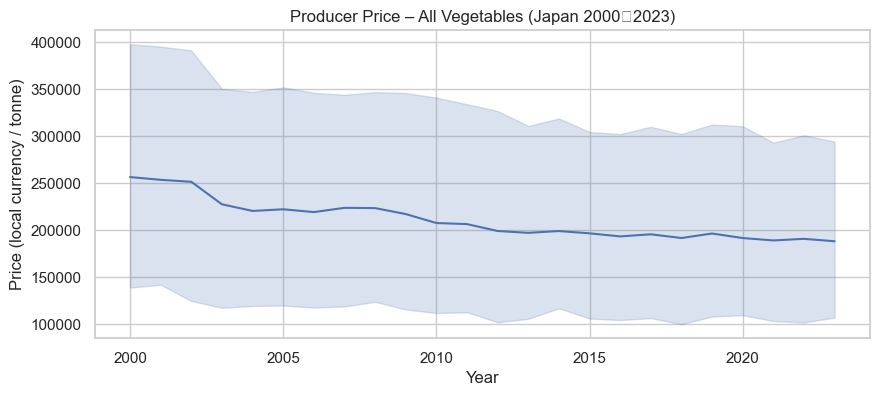

In [8]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="Year", y="Value")
plt.title("Producer Price – All Vegetables (Japan 2000‑2023)")
plt.ylabel("Price (local currency / tonne)")
plt.show()


## 💾 Save Snapshot

Save a snapshot of the raw dataframe for reproducibility.

In [9]:
SNAPSHOT = "jp_veg_clean_snapshot.csv"
df.to_csv(SNAPSHOT, index=False)
print("Snapshot saved →", SNAPSHOT)
print("✅ Step 1 complete — environment ready & clean data loaded.")


Snapshot saved → jp_veg_clean_snapshot.csv
✅ Step 1 complete — environment ready & clean data loaded.


## 🧹 Data Cleaning

Ensure correct dtypes and fill missing values with item‑level medians.

In [10]:
# 2A‑1  Ensure Year is integer
df["Year"] = df["Year"].astype(int)

# 2A‑2  Look for nulls
null_counts = df.isna().sum()
print("Nulls per column:\n", null_counts[null_counts > 0])

# If Value has gaps, choose one strategy (median per item × year as example)
if null_counts.get("Value", 0) > 0:
    df["Value"] = (
        df.groupby("Item")["Value"]
          .apply(lambda s: s.fillna(s.median()))
    )
    print("Nulls in Value filled with item‑level medians ✅")


Nulls per column:
 Series([], dtype: int64)


## 📏 Winsorise Outliers

Cap extreme spikes using Tukey fences per item.

In [11]:
# Tukey fences per Item
def winsorise(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return series.clip(lower, upper)

df["Value_winsor"] = (
    df.groupby("Item")["Value"]
      .transform(winsorise)
)

print("Winsorisation done — compare df[['Value','Value_winsor']].head()")


Winsorisation done — compare df[['Value','Value_winsor']].head()


## 🛠️ Feature Engineering

Compute YoY returns, log returns and create lag features.

In [14]:
# 2C‑1  YoY percentage change
df["YoY_Return"] = (
    df.groupby("Item")["Value_winsor"]
      .pct_change()
)

# 2C‑2  Log‑returns (optional)
df["Log_Return"] = np.log1p(df["YoY_Return"])

# 2C‑3  Lag up to 3 years (for classical models / risk score)
for lag in [1, 2, 3]:
    df[f"Value_lag{lag}"] = (
        df.groupby("Item")["Value_winsor"].shift(lag)
    )


## 📉 Rolling Volatility

Add 3‑year and 5‑year rolling standard deviations of returns.

In [15]:
windows = [3, 5]           # 3‑year & 5‑year rolling std
for w in windows:
    df[f"Vol_{w}y"] = (
        df.groupby("Item")["YoY_Return"]
          .rolling(window=w, min_periods=1)
          .std()
          .reset_index(level=0, drop=True)
    )


## 🧼 Finalise Feature Set

Drop residual NaNs and save engineered feature CSV.

In [16]:
# Drop any rows that still have NaNs after engineering
before = len(df)
df_feat = df.dropna().reset_index(drop=True)
after  = len(df_feat)
print(f"Dropped {before - after} rows with residual NaNs (kept {after}).")


Dropped 81 rows with residual NaNs (kept 1797).


In [17]:
FEATURE_PATH = "jp_veg_features.csv"
df_feat.to_csv(FEATURE_PATH, index=False)
print("✅ Step 2 complete – features saved to →", FEATURE_PATH)


✅ Step 2 complete – features saved to → jp_veg_features.csv


## 🤖 Modelling Setup

Import modelling libs and define hyperparameters.

In [18]:
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error

# 3A‑1  Load engineered dataset
df_feat = pd.read_csv("jp_veg_features.csv")

# 3A‑2  Key hyper‑parameters
WINDOW   = 5   # look‑back steps (years)
HORIZON  = 1   # forecast one step ahead
EPOCHS   = 150
BATCH_SZ = 8
TEST_SPLIT = 0.2  # 80‑20 train‑test


## 🧩 Helper Functions

Sequence builder and LSTM architecture.

In [19]:
def make_sequences(series: np.ndarray, window=WINDOW, horizon=HORIZON):
    X, y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i : i + window])
        y.append(series[i + window : i + window + horizon])
    X = np.array(X)[..., None]  # (samples, timesteps, features=1)
    y = np.array(y)
    return X, y


In [20]:
from tensorflow.keras import layers, models

def build_lstm(window=WINDOW):
    model = models.Sequential([
        layers.Input(shape=(window, 1)),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)  # horizon = 1
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


## 🎯 Train & Evaluate One Vegetable

Train an LSTM on one chosen vegetable and report metrics.

In [21]:
# 3D‑1  Pick a vegetable
VEG = "Tomatoes"   # <-- change or run this cell multiple times per veg

# 3D‑2  Extract the series (winsorised value)
series = (
    df_feat[df_feat["Item"] == VEG]
    .sort_values("Year")["Value_winsor"]
    .values
    .astype("float32")
)

# Ensure enough points
if len(series) <= WINDOW + 3:
    raise ValueError(f"Not enough data points for {VEG}. Need > {WINDOW+3}")

# 3D‑3  Make train‑test split
X, y = make_sequences(series, WINDOW, HORIZON)
split = int(len(X) * (1 - TEST_SPLIT))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3D‑4  Build & train model
tf.keras.backend.clear_session()
model = build_lstm(WINDOW)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SZ,
    verbose=0,
    validation_data=(X_test, y_test)
)
print(f"Training done for {VEG}. Last val_loss: {history.history['val_loss'][-1]:.4f}")






Training done for Tomatoes. Last val_loss: 197451776000.0000


In [22]:
# Predictions on test set
preds = model.predict(X_test).flatten()
y_true = y_test.flatten()

# 3E‑1  MAPE
mape = mean_absolute_percentage_error(y_true, preds) * 100

# 3E‑2  Directional accuracy
directional = (
    np.sign(np.diff(y_true)) == np.sign(np.diff(preds))
).mean() * 100

print(f"{VEG} → MAPE {mape:.2f}% | Directional {directional:.1f}%")


1/1 [==============================] - 2s 2s/step
Tomatoes → MAPE 99.66% | Directional 0.0%


In [23]:
# 3F‑1  Forecast next period
next_val = model.predict(series[-WINDOW:].reshape(1, WINDOW, 1))[0, 0]
print(f"Next‑year forecast for {VEG}: {next_val:,.0f} (same units as Value)")

# 3F‑2  Save model (optional)
model_path = f"lstm_{VEG.lower().replace(' ', '_')}.keras"
model.save(model_path)
print("Model saved →", model_path)


1/1 [==============================] - 0s 42ms/step
Next‑year forecast for Tomatoes: 104 (same units as Value)
Model saved → lstm_tomatoes.keras


## 🔁 Train All Vegetables

Loop through all vegetables, train models, collect metrics.

In [24]:
results = []

for veg in df_feat["Item"].unique():
    series = df_feat[df_feat["Item"] == veg].sort_values("Year")["Value_winsor"].values.astype("float32")
    if len(series) <= WINDOW + 3:
        continue
    X, y = make_sequences(series)
    split = int(len(X) * (1 - TEST_SPLIT))
    Xtr, Xte, ytr, yte = X[:split], X[split:], y[:split], y[split:]

    tf.keras.backend.clear_session()
    m = build_lstm(WINDOW)
    m.fit(Xtr, ytr, epochs=EPOCHS, batch_size=BATCH_SZ, verbose=0)
    preds = m.predict(Xte).flatten()

    mape  = mean_absolute_percentage_error(yte.flatten(), preds) * 100
    direc = (np.sign(np.diff(yte.flatten())) == np.sign(np.diff(preds))).mean() * 100
    results.append((veg, mape, direc))

df_metrics = pd.DataFrame(results, columns=["Item", "MAPE%", "Directional%"])
df_metrics.sort_values("MAPE%").head()


1/1 [==============================] - 1s 950ms/step


,Item,MAPE%,Directional%
0,Asparagus,97.855258,0.0
11,Green garlic,98.029923,0.0
17,"Peas, green",98.457611,0.0
1,"Broad beans and horse beans, green",98.867148,0.0
21,String beans,98.906410,0.0


## ⚖️ Risk Scoring

Compute composite risk score (volatility, exposure, supply risk) and save table.

In [25]:
df_feat = pd.read_csv("jp_veg_features.csv")

# Exposure proxy → mean tonnage or a constant if unavailable
if "Production_Tonnes" in df_feat.columns:
    exposure = (
        df_feat.groupby("Item")["Production_Tonnes"]
        .transform("mean")
    )
else:
    exposure = 1   # fallback

df_feat["Exposure"] = exposure

# Supply‑risk proxy → inverse of production growth stability
df_feat["SupplyRisk"] = (
    df_feat.groupby("Item")["YoY_Return"]
           .transform("std")
).fillna(df_feat["YoY_Return"].std())


In [26]:
latest_year = df_feat["Year"].max()
df_latest = df_feat[df_feat["Year"] == latest_year].copy()

for col in ["Vol_5y", "Exposure", "SupplyRisk"]:
    mn, mx = df_latest[col].min(), df_latest[col].max()
    df_latest[col + "_norm"] = (df_latest[col] - mn) / (mx - mn + 1e-9)

df_latest["RiskScore"] = (
    0.5 * df_latest["Vol_5y_norm"] +
    0.3 * df_latest["Exposure_norm"] +
    0.2 * df_latest["SupplyRisk_norm"]
)

risk_table = (
    df_latest[["Item", "RiskScore", "Vol_5y", "Exposure", "SupplyRisk"]]
    .sort_values("RiskScore", ascending=False)
    .reset_index(drop=True)
)

risk_table.head()


,Item,RiskScore,Vol_5y,Exposure,SupplyRisk
0,"Other vegetables, fresh n.e.c.",0.700000,67.702814,1,55.441456
1,"Other vegetables, fresh n.e.c.",0.698715,67.528808,1,55.441456
2,"Other vegetables, fresh n.e.c.",0.607703,55.207788,1,55.441456
3,Potatoes,0.425405,38.877906,1,38.351675
4,Potatoes,0.422405,38.471870,1,38.351675


In [27]:
risk_table.to_csv("veg_risk_scores.csv", index=False)
print("Risk table saved ✅")


Risk table saved ✅
